In [1]:
from astrodendro import Dendrogram, pp_catalog
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
import regions
import numpy as np
from astropy import coordinates
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import QTable, Table, Column
import matplotlib.cm as cm
from pyregion.mpl_helper import properties_func_default
from astropy.visualization import simple_norm
from astropy.stats import mad_std
from regions import DS9Parser
import re
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion
import warnings
from astropy import visualization
from astropy.stats import mad_std

In [ ]:
cd

In [2]:
cd /orange/adamginsburg/sgrb2/NB

/orange/adamginsburg/sgrb2/NB


In [3]:
def read_in(path):
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
    data=fh[0].data
    return data, wcs

In [4]:
def basefigure(data):
    tick_fontsize = 14
    fontsize = 16
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(projection=wcs_out)
    im = ax.imshow(data, cmap='gray_r', norm=norm1)
    
    divider = make_axes_locatable(ax)
    cax = fig.add_axes([ax.get_position().x1-0.1,
        ax.get_position().y0,
        0.02,
        ax.get_position().height])

    cb = plt.colorbar(mappable=im, cax=cax)
    cb.ax.tick_params(labelsize=tick_fontsize)
    ax.axis([167,1617,210,1618])

    
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    radesys = wwM.wcs.radesys
    ra.set_axislabel(f"RA ({radesys})", fontsize=fontsize)
    dec.set_axislabel(f"Dec ({radesys})", fontsize=fontsize, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticklabel(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticklabel(exclude_overlapping=True)
    ax.axis([0,7719,0,10579])
    return fig, ax

In [5]:
def set_up_regions(path,wX):
    includeX = regions.read_ds9(path)
    strX = regions.ds9_objects_to_string(includeX)
    start = []
    for m in re.finditer('source=1', strX):
        start += [m.end()]
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        strM = strX[:loc] + ' text={source_' + x +'}' + strX[loc:]
    parser = DS9Parser(strX)
    regionsX = parser.shapes.to_regions()
    #regions.write_ds9(regionsX, 'regionsX_text.reg')
    pixelX = [region.to_pixel(wX) for region in includeX]
    return includeX, regionsX, pixelX

In [6]:
def set_up_catalog(d,wX,includeX,min_value,min_delta,min_npix):
    #d = Dendrogram.compute(dM, min_value = min_value, min_delta=min_delta, min_npix = min_npix)
    cat = pp_catalog(d.leaves,metadata={'data_unit':u.Jy,'wcs': wX},verbose=False)
    purgeX = []
    for i in range(len(d)):
        if d[i].level > 5: 
            purgeX += [d[i].idx]
    coordsX = coordinates.SkyCoord(cat['x_cen'], cat['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    containsX = np.zeros(len(cat),dtype=bool)
    for X in includeX:
        containsX[X.contains(coordsX, wX)] = 1
    print('Total detections before cutting down: '+str(np.sum(containsX)))
    cat_cut = cat[containsX]
    cat_final= cat_cut[:0].copy()
    for i in range(len(cat_cut)):    
        if cat_cut['_idx'][i] not in purgeX:
            cat_final.add_row(cat_cut[i])
    print('Total detections after removal: '+str(len(cat_final)))
    cat_coords = coordinates.SkyCoord(cat_final['x_cen'], cat_final['y_cen'], unit=(u.deg,u.deg), frame=wX.celestial.wcs.radesys.lower())
    return cat_coords, cat_final

In [7]:
def quicklook(image,
              overview_cmap='gray_r',
                  inner_stretch='log',
                  inner_maxpct=100,
                  inset_cmap='inferno',
                  band='B3',
                  nsigma_linear_max=15,
                  nsigma_linear_min=5,
                  nsigma_asinh=15,
                  pfxs=None,
                  finaliter_prefix=None,
                  region=None,
                  fig=None,
                  ax=None,
                  ):
    wl = r'\mathrm{3mm}' if band.lower() == 'b3' else r'\mathrm{1mm}'
    if fig is None:
        fig = plt.figure(1, figsize=(12,10))
        fig.clf()
    if ax is None:
        ax = fig.add_subplot(projection=wM.celestial)
    img = image
    #img = image[0].value
    #img[img==0] = np.nan
    mad = mad_std(img, ignore_nan=True)
    norm = simple_norm(img, stretch='linear', min_cut=-nsigma_linear_min*mad, max_cut=nsigma_linear_max*mad,)
    #norm = simple_norm(image, 'sqrt', percent=99.85)
    im1 = ax.imshow(img, cmap=overview_cmap, norm=norm)
    cm = plt.cm.get_cmap(inset_cmap)
    cm.set_under((0,0,0,0))
    vmin = norm.vmax*0.99
    norm2 = simple_norm(img, min_cut=vmin, stretch=inner_stretch, max_percent=inner_maxpct)
    norm2.vmin = vmin
    if hasattr(norm2.stretch, 'a') and nsigma_asinh is not None:
        #norm2.vmax = (np.nanmedian(img) + nsigma_max*mad)
        a_point = (vmin + nsigma_asinh*mad) / (norm2.vmax - vmin)
        #print(f"a point before: {norm2.stretch.a}, after: {a_point}")
        norm2.stretch.a = a_point
    im2 = ax.imshow(img, cmap=cm, norm=norm2, vmin=norm2.vmin)
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    #divider = make_axes_locatable(ax)
    #cax1 = divider.append_axes("right", size="5%", pad=0.05)
    #cax2 = divider.append_axes("right", size="5%", pad=0.1)
    cax1 = fig.add_axes([ax.get_position().x1+0.01,
                         ax.get_position().y0,
                         0.02,
                         ax.get_position().height])
    cax2 = fig.add_axes([ax.get_position().x1+0.08,
                         ax.get_position().y0,
                         0.02,
                         ax.get_position().height])
    cb2 = plt.colorbar(mappable=im2, cax=cax2)
    cb1 = plt.colorbar(mappable=im1, cax=cax1)
    cb1.ax.tick_params(labelsize=14)
    cb2.ax.tick_params(labelsize=14)
    ticklabels = cb2.ax.get_ymajorticklabels()
    ticks = list(cb2.get_ticks())
    #if inner_stretch in ('asinh', 'log'):
        #rounded_loc, rounded = determine_asinh_ticklocs(norm2.vmin, norm2.vmax, nticks=10, stretch=inner_stretch)
        #cb2.set_ticks(rounded_loc)
        #cb2.set_ticklabels(rounded)
        #print(f"old ticks: {ticklabels}, new ticks: {rounded}")
    cb2.set_label(f"S$_{wl}$ [mJy beam$^{{-1}}$]", fontsize=14)
    tick_fontsize=16
    ra = ax.coords['ra']
    ra.set_major_formatter('hh:mm:ss.s')
    dec = ax.coords['dec']
    ra.set_axislabel("RA (J2000)", fontsize=20)
    dec.set_axislabel("Dec (J2000)", fontsize=20, minpad=0.0)
    ra.ticklabels.set_fontsize(tick_fontsize)
    ra.set_ticks(exclude_overlapping=True)
    dec.ticklabels.set_fontsize(tick_fontsize)
    dec.set_ticks(exclude_overlapping=True)
    #ell = image.beam.ellipse_to_plot(0.05*img.shape[1], 0.05*img.shape[0], pixscale=wM.celestial.pixel_scale_matrix[1,1]*u.deg)
    #ax.add_patch(ell)
    return fig, ax

In [28]:
# def regions_gaussfit(cat_final):
#     centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
#     radiusX = Angle(cat_final['radius'].value*0.02, unit='arcsec')
#     cat_regionsX = []
#     for i in range(len(centerX)):
#         cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
#     str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX)
#     start = []
#     for m in re.finditer('\)', str_cat_regionsX):
#         start += [m.end()]
#     str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 text={source_'
#     str2 = '} color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman"'
#     for i in range(len(start)):
#         loc = start[-1-i]
#         x = str(i+1)
#         str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
#     parser = DS9Parser(str_cat_regionsX)
#     str_cat_regionsx = parser.shapes.to_regions()
#     #regions.write_ds9(str_cat_regionsX, "regionsN_text.reg")
#     return str_cat_regionsX

In [113]:
cat_finalM

_idx,area_ellipse,area_exact,flux,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen
,pix2,pix2,Jy,pix,pix,deg,pix,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1961,41.70259965525564,137.0,0.045191165700089186,4.022407192744588,2.3805601569562858,102.16200361257182,3.094443778468458,266.832796598954,-28.398390017411582
2501,5.944412106754264,21.0,0.00540877650200855,1.4587171303459374,0.9357070276771896,154.79729699062108,1.168302987352937,266.8314493175509,-28.39813409895524
2795,77.21742779274163,328.0,0.16433138342108577,5.456909266597646,3.2491567398055117,152.188552960124,4.2107426330842035,266.8287668855427,-28.397909241070796
3215,12.588501327973937,42.0,0.01179627818055451,2.2765753386885192,1.269679382491897,126.15421995554361,1.7001531608129665,266.83213442952336,-28.397654944859852
3220,14.681513720913587,42.0,0.009634316083975136,2.733522975626278,1.2332472938170262,-146.9700687891999,1.83605822682119,266.83226848871516,-28.397647019253398
3650,93.33294566992049,307.0,0.12587492643797304,6.156488047223515,3.480999785198654,125.39765378026092,4.629334030933946,266.831562208513,-28.39720431058134
3842,18.390698587267067,48.0,0.010977277503116056,3.5000406908921273,1.2064996424971617,157.25145569814777,2.054944729740163,266.8350616753108,-28.397079676696286
3943,12.274064613913447,40.0,0.05259827495319769,2.3747665107975524,1.1867781824561636,118.15392725636794,1.6787855978182815,266.8332691524251,-28.39691926623256


In [ ]:
radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')

In [111]:
def regions_gaussfit(cat_final):
    centerX = SkyCoord(cat_final['x_cen'], cat_final['y_cen'],unit='deg')
    radiusX = Angle(cat_final['radius'][::-1].value*.0000055, unit='deg')
    #radiusX = Angle(cat_final['radius'][::-1].value*0.02, unit='arcsec')
    cat_regionsX = []
    for i in range(len(centerX)):
        cat_regionsX += [CircleSkyRegion(centerX[i], radiusX[i])]
    str_cat_regionsX = regions.ds9_objects_to_string(cat_regionsX)
    start = []
    for m in re.finditer('\)', str_cat_regionsX):
        start += [m.end()]
    str1 = ' # select=1 highlite=1 fixed=0 edit=1 move=1 delete=1 source=1 color=#2EE6D6 dashlist=8 3 width=2 dash=0 font="helvetica 10 normal roman" text={source_'
    str2 = '}'
    for i in range(len(start)):
        loc = start[-1-i]
        x = str(i+1)
        str_cat_regionsX = str_cat_regionsX[:loc] + str1 + x + str2 + str_cat_regionsX[loc:]
    parser = DS9Parser(str_cat_regionsX)
    str_cat_regionsX = parser.shapes.to_regions()
    regions.write_ds9(str_cat_regionsX, "regionsN_text_degrees.reg")
    #return str_cat_regionsX

In [112]:
regions_gaussfit(cat_finalN)

In [9]:
def makefig(data,catX_pixel,pixelX,xl=0,xu=5488,yl=0,yu=5488):
    mad = mad_std(data, ignore_nan=True)
    norm = visualization.simple_norm(data, stretch='linear', min_cut=-3*mad, max_cut=8*mad,)
    fig = plt.figure(figsize=(10, 10), dpi=80)
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8])
    fig.add_axes(ax)
    ax.axis([xl,xu,yl,yu])
    ax.imshow(data, cmap='Greys', norm=norm, origin="lower")

    cm = plt.cm.get_cmap('inferno')
    cm.set_under((0,0,0,0))
    vmin = norm.vmax*0.99
    norm2 = visualization.simple_norm(data, min_cut=vmin, stretch='log', max_percent=100)
    norm2.vmin = vmin
    im2 = ax.imshow(data, cmap='inferno',norm=norm2)

    ax.plot(catX_pixel[0],catX_pixel[1],'X',alpha=1,color='aqua')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for region in pixelX: 
            region.plot(color='green',alpha=1,fill=False)

2300,2800,400,900 DS

2500,3000,1500,1800]) #MN

2600,3000,2400,3000 #N

2400,3000,2400,3000 #M

In [10]:
pathN='NB.sgr_b2.N.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'
pathM='NB.sgr_b2.M.B3.cont.pb0.1.r0.5.clean500k0.1mjy.pcal2.image.tt0.pbcor.fits'

In [11]:
Ncal, wN = read_in(pathN)
Mcal, wM = read_in(pathM)

In [12]:
regionsM_path='/orange/adamginsburg/sgrb2/NB/SgrB2M_YSO_regions.reg'
regionsN_path='/orange/adamginsburg/sgrb2/NB/SgrB2N_YSO_regions.reg'

In [13]:
includeM, regionsM, pixelM = set_up_regions(regionsM_path,wM)
includeN, regionsN, pixelN = set_up_regions(regionsN_path,wN)

In [14]:
dN = Dendrogram.compute(Ncal, min_value = 0.00015, min_delta=0.00005, min_npix = 10)
dM = Dendrogram.compute(Mcal, min_value = 0.00015, min_delta=0.0001, min_npix = 10)

In [15]:
cat_coordsM, cat_finalM = set_up_catalog(dM,wM,includeM,0.00015,0.0001,10)

Total detections before cutting down: 183
Total detections after removal: 164


In [16]:
cat_coordsN, cat_finalN = set_up_catalog(dN,wN,includeN,0.00015,0.0001,10)

Total detections before cutting down: 160
Total detections after removal: 149


In [17]:
catM_pixel = wM.world_to_pixel(cat_coordsM)
catN_pixel = wN.world_to_pixel(cat_coordsN)

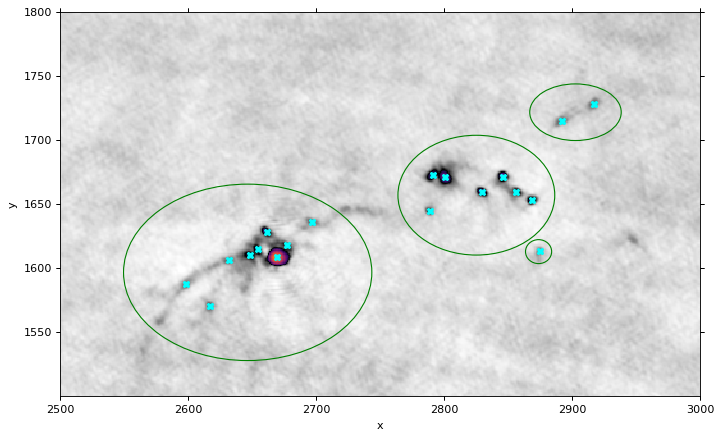

In [72]:
makefig(Ncal,catN_pixel,pixelN,2500,3000,1500,1800)

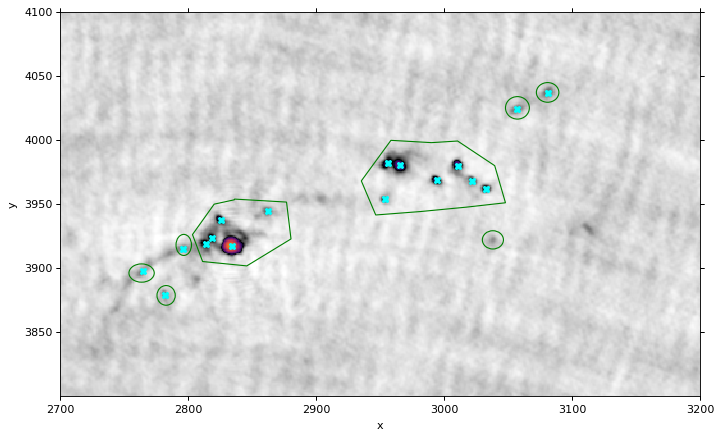

In [76]:
makefig(Mcal,catM_pixel,pixelM,2700,3200,3800,4100)

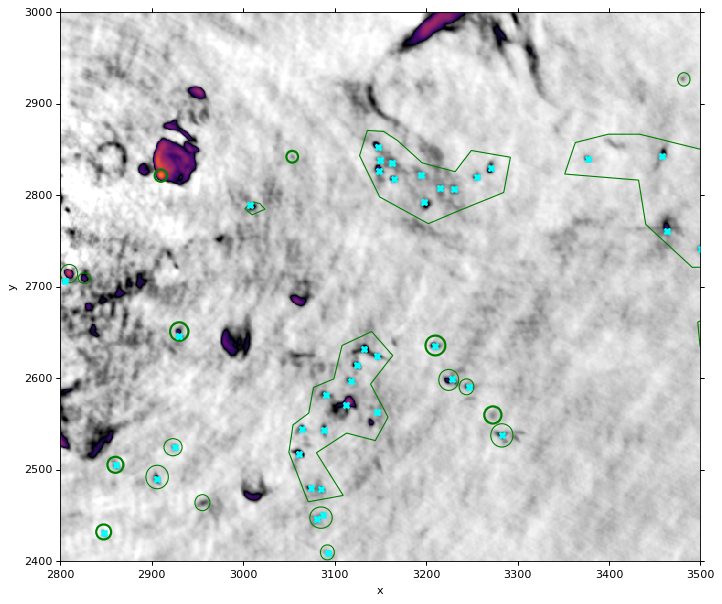

In [90]:
makefig(Mcal,catM_pixel,pixelM,2800,3500,2400,3000)

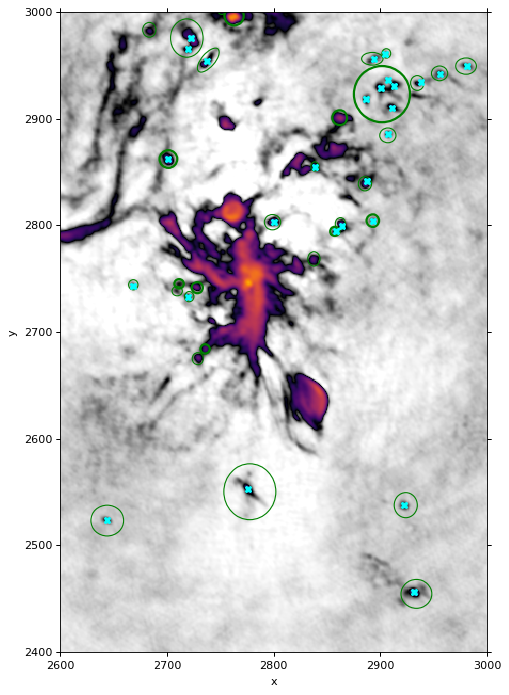

In [114]:
makefig(Ncal,catN_pixel,pixelN,2600,3000,2400,3000)

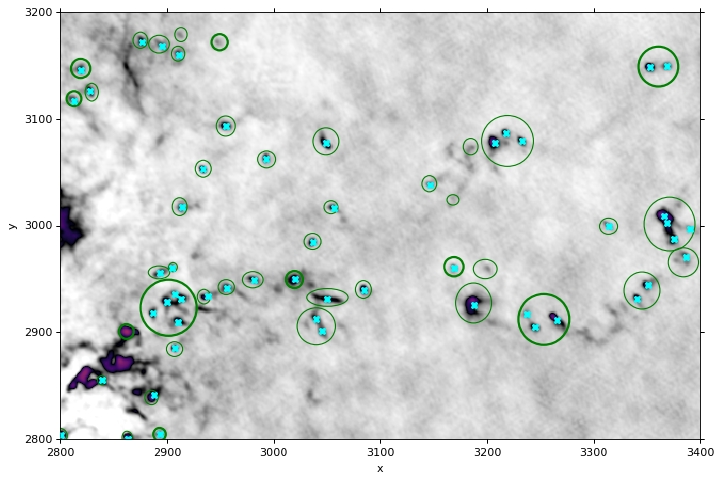

In [122]:
makefig(Ncal,catN_pixel,pixelN,2800,3400,2800,3200)